In [15]:
!pip install -q monai-weekly[all]

In [16]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    ToTensorD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp

import numpy as np
import torch
import matplotlib.pyplot as plt
import tempfile
import sys
import shutil
import os
import logging
from monai.apps import MedNISTDataset

print_config()
set_determinism(42)

MONAI version: 0.5.dev2112
Numpy version: 1.19.5
Pytorch version: 1.8.0+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 2f993ec35495e012ed2cb07c31d4f1e497533a58

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.0.0
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.9.0+cu101
ITK version: 5.1.2
tqdm version: 4.59.0
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Construct pairwise training inputs
We use the `MedNISTDataset` object to download and unzip the actual data files.
Then we select the hand class, convert the loaded data dicts into "fixed_hand" and "moving_hand" which will be preprocessed differently to create synthetic training pairs.

In [17]:
train_data = MedNISTDataset(root_dir="./", section="training", download=True, transform=None)
training_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
]
print("\n first training items: ", training_datadict[:3])

Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
file ./MedNIST.tar.gz exists, skip downloading.
extracted file ./MedNIST exists, skip extracting.


Loading dataset: 100%|██████████| 47164/47164 [00:00<00:00, 136036.38it/s]


 first training items:  [{'fixed_hand': './MedNIST/Hand/002717.jpeg', 'moving_hand': './MedNIST/Hand/002717.jpeg'}, {'fixed_hand': './MedNIST/Hand/000931.jpeg', 'moving_hand': './MedNIST/Hand/000931.jpeg'}, {'fixed_hand': './MedNIST/Hand/007661.jpeg', 'moving_hand': './MedNIST/Hand/007661.jpeg'}]


In [18]:
train_transforms = Compose(
    [
        LoadImageD(keys=["fixed_hand", "moving_hand"]),
        EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
        ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"], a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
        RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, padding_mode="reflection"),
        RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
        ToTensorD(keys=["fixed_hand", "moving_hand"]),
    ]
)

moving_image shape: torch.Size([64, 64])
fixed_image shape: torch.Size([64, 64])


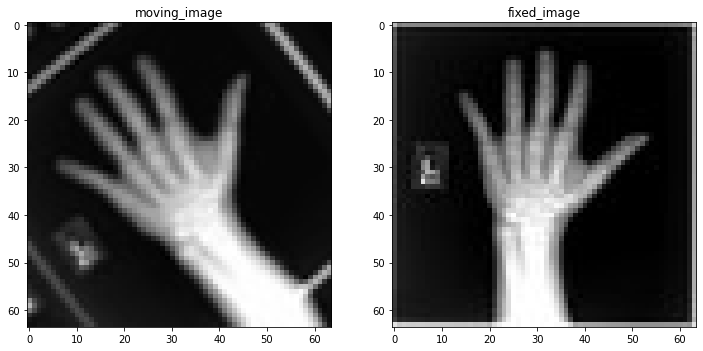

In [19]:
check_ds = Dataset(data=training_datadict, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)
fixed_image = check_data["fixed_hand"][0][0]
moving_image = check_data["moving_hand"][0][0]

print(f"moving_image shape: {moving_image.shape}")
print(f"fixed_image shape: {fixed_image.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(moving_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("fixed_image")
plt.imshow(fixed_image, cmap="gray")

plt.show()

In [20]:
train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                        cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

Loading dataset: 100%|██████████| 1000/1000 [00:01<00:00, 817.00it/s]


In [21]:
from torch.nn import MSELoss
from monai.losses import BendingEnergyLoss
from torch import nn

device = torch.device("cuda:0")
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)
model.output_block.fc.weight.data.zero_()
model.output_block.fc.bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
image_loss = MSELoss()
warp_layer = Warp(spatial_dims=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

In [ ]:
epoch_num = 200
val_interval = 2
best_metric, best_metric_epoch = -1, -1
epoch_loss_values, metric_values = [], []

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss, step = 0, 0
    for batch_data in train_loader:
        step += 1
        optimizer.zero_grad()

        moving = batch_data["moving_hand"].to(device)
        fixed = batch_data["fixed_hand"].to(device)
        ddf = model(torch.cat((moving, fixed), dim=1))
        pred_image = warp_layer(moving, ddf)

        loss = image_loss(pred_image, fixed)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #       f"train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

# Visualise some validation results

In [25]:
val_ds = CacheDataset(data=training_datadict[2000:2500], transform=train_transforms,
                      cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)
for batch_data in val_loader:
    moving = batch_data["moving_hand"].to(device)
    fixed = batch_data["fixed_hand"].to(device)
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

Loading dataset: 100%|██████████| 5998/5998 [00:05<00:00, 1186.59it/s]


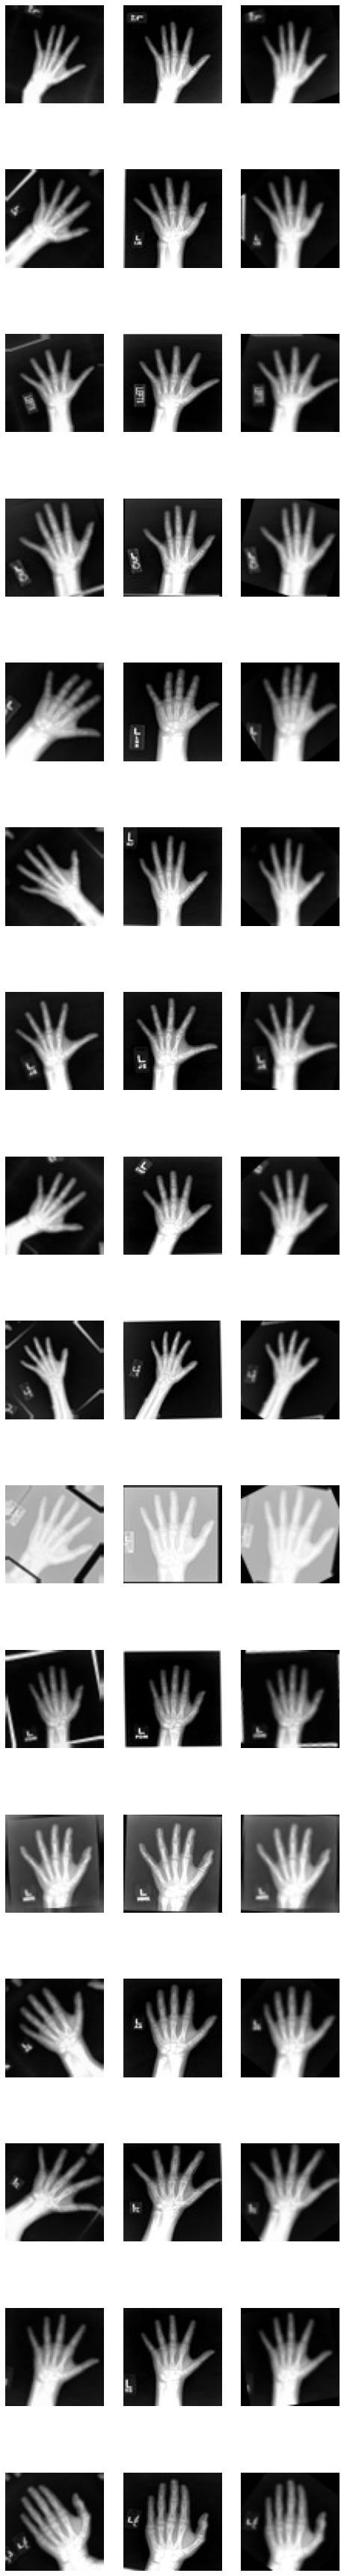

In [26]:
%matplotlib inline
batch_size = len(fixed_image)
plt.subplots(batch_size, 3, figsize=(8, 64))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 3, b * 3 + 1); plt.axis('off')
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 3, b * 3 + 2); plt.axis('off')
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 3, b * 3 + 3); plt.axis('off')
    plt.imshow(pred_image[b], cmap="gray")
plt.axis('off')
plt.show()